# **Deep Learning applied on Nairobi slum**

## Import libraries

In [1]:
import tensorflow as tf
import os, sys
import numpy as np
import h5py

In [2]:
from stackage import stackage

In [3]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [4]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

## Importing data

In [5]:
data_path = 'Images/S2/merge_RGBNIR_patch/'
data_name = "RGBNIR.hdf5"
path_raster = import_hf5(data_path,data_name,'raster')

patch_id_train = import_hf5(data_path,data_name,'id_train')
patch_id_test = import_hf5(data_path,data_name,'id_test')

patch_lulc_train = import_hf5(data_path,data_name,"lulc_train")
patch_lulc_test = import_hf5(data_path,data_name,"lulc_test")

patch_id = import_hf5(data_path,data_name,"patch_id")

## Separate train patchs to test patchs

In [6]:
train_path = []
test_path = []

patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
patch_id_train_list = patch_id_train_re.tolist()[0]
patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
patch_id_test_list = patch_id_test_re.tolist()[0]

for path in path_raster : #récupération des id des images
    image = path.split(b'/')[-1]
    image_id = int(image.split(b'_')[-2])
    if image_id in patch_id_train_list :
        train_path.append(path)
    elif image_id in patch_id_test_list :
        test_path.append(path)

In [ ]:
stack = stackage(train_path)
stack_train = normalise_01(stack)
stack = stackage(test_path)

# **Starting deep learning**


## **Model based on the tutorial**

### Creating model

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(10, 10, 4)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  tf.keras.layers.Dropout(0.4, name = 'fc1_drop', seed=3)
])


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          592       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 32)          4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.798:
      print("\n Enough accuracy")
      self.model.stop_training = True
        
callbacks = myCallback()

### Training model

In [ ]:
history = model.fit(stack_train, patch_lulc_train, epochs=50, batch_size=5, callbacks=[callbacks])

**L'accuracy** : 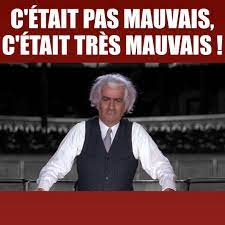

### Evaluating model

In [23]:
model.evaluate(stack_test,patch_lulc_test)

6/6 [==============================] - 0s 8ms/step - loss: 0.5040 - accuracy: 0.7989


[0.5039524435997009, 0.7989130616188049]

In [29]:
data_path = 'Images/S2/grid_RGBNIR_patch/'
data_name = "grid.hdf5"
path_grid_raster = import_hf5(data_path,data_name,'raster')
patch_id_raster = import_hf5(data_path,data_name,'patch_id')

In [ ]:
stack = stackage(path_grid_raster)

In [19]:
stack_grid = normalise_01(stack)

In [63]:
predict = model.predict(stack_grid)

143/143 [==============================] - 1s 4ms/step


In [65]:
print(predict)

[[0.72126716]
 [0.7223747 ]
 [0.7251143 ]
 ...
 [0.7859904 ]
 [0.7407204 ]
 [0.7629363 ]]


In [21]:
#patch_id_raster = np.array(patch_id_raster.reshape(patch_id_raster.size,1))

In [58]:
patch_id_raster = patch_id_raster.tolist()

In [38]:
print(min(predict))

0.6342427134513855


## **Y Model**

# **Garbage**

In [60]:
import csv

#predict = predict.reshape(1,predict.size).tolist()[0]

header = ['prob_slum','id']
cont = []
cont.append(header)
for x,y in zip(predict,patch_id_raster):
    current_row = [x,y]
    cont.append(current_row)
    
cont

with open('prob_slum.csv','w') as file :
    write = csv.writer(file)
    write.writerows(cont)

In [93]:
a = ['a','b','c']
b = [1,2,3]
content = []
header = ["col1", "col2"]
content.append(header)
for x,y in zip(a,b):
    current_row = [x,y]
    content.append(current_row)
    
content

import csv
with open('example.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(content)

In [86]:
tuple_

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)